In [1]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [4]:
cd "/content/gdrive/My Drive/Spam data"

/content/gdrive/My Drive/Spam data


In [5]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


**Data Preprocessing**

In [0]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)

In [0]:
# Replace ham with 0 and spam with 1
df = df.replace(['ham','spam'],[0, 1])

In [8]:
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


**Check lenght of each text**

In [9]:
df['Count']=0
for i in np.arange(0,len(df.v2)):
    df.loc[i,'Count'] = len(df.loc[i,'v2'])

df.head()

,v1,v2,Count
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [10]:
df['Count'].quantile([0,0.25,0.5,0.75,0.9,1])

0.00      2.0
0.25     36.0
0.50     61.0
0.75    121.0
0.90    156.0
1.00    910.0
Name: Count, dtype: float64

Group text for further analysis

In [11]:
bins = [0, 50, 100, 150, 200, 250, 1000]
df['binned'] = pd.cut(df['Count'], bins)
df.head()

,v1,v2,Count,binned
0,0,"Go until jurong point, crazy.. Available only ...",111,"(100, 150]"
1,0,Ok lar... Joking wif u oni...,29,"(0, 50]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,"(150, 200]"
3,0,U dun say so early hor... U c already then say...,49,"(0, 50]"
4,0,"Nah I don't think he goes to usf, he lives aro...",61,"(50, 100]"


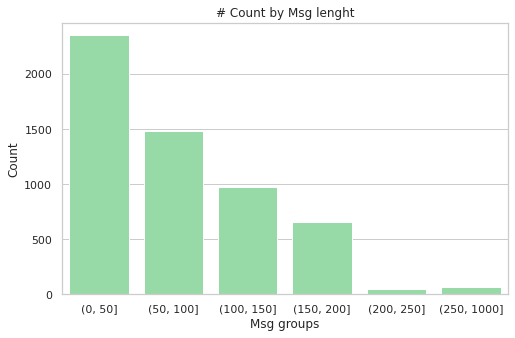

In [12]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8, 5))

# Plot the total items per category
sns.set_color_codes("pastel")
sns.barplot(x="index", y='binned', data=df['binned'].value_counts().reset_index(),
            label="# Items", color="g")

# Add a legend and informative axis label
ax.set( ylabel="Count", title='# Count by Msg lenght',
       xlabel="Msg groups")

plt.show()

General lenght of spam messages

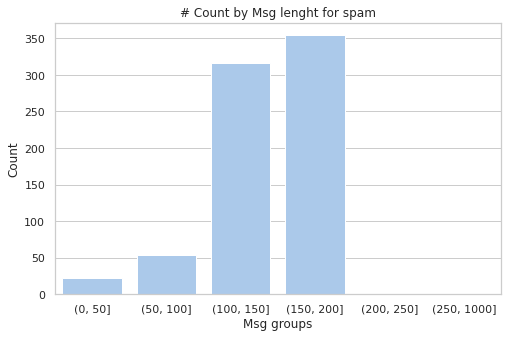

In [13]:
df_spam=df[df['v1']==1]

sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8, 5))

# Plot the total items per category
sns.set_color_codes("pastel")
sns.barplot(x="index", y='binned', data=df_spam['binned'].value_counts().reset_index(),
            label="# Items", color="b")

# Add a legend and informative axis label
ax.set( ylabel="Count", title='# Count by Msg lenght for spam',
       xlabel="Msg groups")

plt.show()


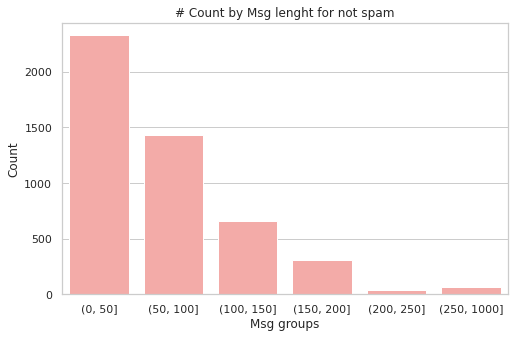

In [16]:
df_not_spam=df[df['v1']==0]

sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8, 5))

# Plot the total items per category
sns.set_color_codes("pastel")
sns.barplot(x="index", y='binned', data=df_not_spam['binned'].value_counts().reset_index(),
            label="# Items", color="r")

# Add a legend and informative axis label
ax.set( ylabel="Count", title='# Count by Msg lenght for not spam',
       xlabel="Msg groups")

plt.show()

**Top Words used in spam**

In [0]:
corpus = []
ps = PorterStemmer()

In [0]:
for i in list(df_spam.index):

    # Applying Regular Expression
    
    '''
    Replace email addresses with 'emailaddr'
    Replace URLs with 'httpaddr'
    Replace money symbols with 'moneysymb'
    Replace phone numbers with 'phonenumbr'
    Replace numbers with 'numbr'
    '''
    msg = df_spam['v2'][i]
    msg = re.sub('\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', df_spam['v2'][i])
    msg = re.sub('(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr', df_spam['v2'][i])
    msg = re.sub('£|\$', 'moneysymb', df_spam['v2'][i])
    msg = re.sub('\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b', 'phonenumbr', df_spam['v2'][i])
    msg = re.sub('\d+(\.\d+)?', 'numbr', df_spam['v2'][i])
    
    ''' Remove all punctuations '''
    msg = re.sub('[^\w\d\s]', ' ', df_spam['v2'][i])
    
    
    # Each word to lower case
    msg = msg.lower()    
    
    # Splitting words to Tokenize
    msg = msg.split()    
    
    # Stemming with PorterStemmer handling Stop Words
    msg = [ps.stem(word) for word in msg if not word in set(stopwords.words('english'))]
    
    # preparing Messages with Remaining Tokens
    msg = ' '.join(msg)
    
    # Preparing WordVector Corpus
    corpus.append(msg)

In [37]:
corpus[0]

'free entri 2 wkli comp win fa cup final tkt 21st may 2005 text fa 87121 receiv entri question std txt rate c appli 08452810075over18'

In [0]:
tokens = []
for line in corpus:
      for wrd in line.split(' '):
        if len(wrd)!=1:
          tokens.append(wrd)

In [0]:
neg_freq = nltk.FreqDist(tokens)
data=pd.DataFrame(neg_freq.most_common(20))

In [0]:
#data.head(20)

def plot_bar_x(data):
    # this is for plotting purpose
    index = np.arange(len(data[0].tolist()))
    plt.barh (index, data[1].tolist())
    plt.xlabel('Count', fontsize=8)
    plt.ylabel('Word', fontsize=8)
    plt.yticks(index, data[0].tolist(), fontsize=8, rotation=0)
    ls='Top spam Words'
    plt.title(ls)
    plt.show()

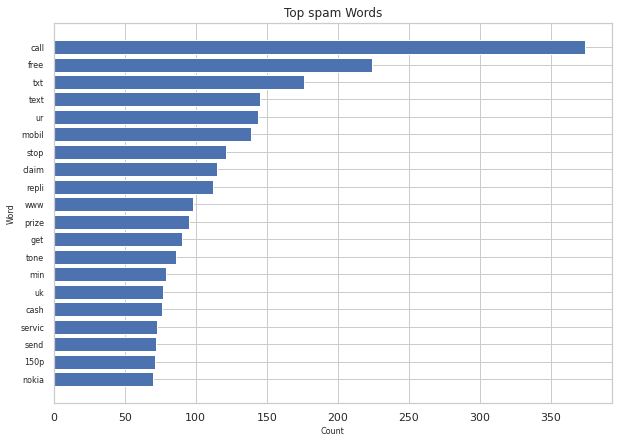

In [62]:
plt.rcParams["figure.figsize"] = (10,7)
plot_bar_x(data.sort_values(1))

In [11]:
# Total ham(0) and spam(1) messages
df['v1'].value_counts()

0    4825
1     747
Name: v1, dtype: int64

**Text cleaning for all messages**

In [0]:
corpus = []

In [18]:
for i in range(0, 5572):

    # Applying Regular Expression
    
    '''
    Replace email addresses with 'emailaddr'
    Replace URLs with 'httpaddr'
    Replace money symbols with 'moneysymb'
    Replace phone numbers with 'phonenumbr'
    Replace numbers with 'numbr'
    '''
    msg = df['v2'][i]
    msg = re.sub('\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', df['v2'][i])
    msg = re.sub('(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr', df['v2'][i])
    msg = re.sub('£|\$', 'moneysymb', df['v2'][i])
    msg = re.sub('\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b', 'phonenumbr', df['v2'][i])
    msg = re.sub('\d+(\.\d+)?', 'numbr', df['v2'][i])
    
    ''' Remove all punctuations '''
    msg = re.sub('[^\w\d\s]', ' ', df['v2'][i])
    
    if i<2:
        print("\t\t\t\t MESSAGE ", i+1)
    
    if i<2:
        print("\n After Regular Expression - Message ", i+1, " : ", msg)
    
    # Each word to lower case
    msg = msg.lower()    
    if i<2:
        print("\n Lower case Message ", i+1, " : ", msg)
    
    # Splitting words to Tokenize
    msg = msg.split()    
    if i<2:
        print("\n After Splitting - Message ", i+1, " : ", msg)
    
    # Stemming with PorterStemmer handling Stop Words
    msg = [ps.stem(word) for word in msg if not word in set(stopwords.words('english'))]
    if i<2:
        print("\n After Stemming - Message ", i+1, " : ", msg)
    
    # preparing Messages with Remaining Tokens
    msg = ' '.join(msg)
    if i<2:
        print("\n Final Prepared - Message ", i+1, " : ", msg, "\n\n")
    
    # Preparing WordVector Corpus
    corpus.append(msg)

				 MESSAGE  1

 After Regular Expression - Message  1  :  Go until jurong point  crazy   Available only in bugis n great world la e buffet    Cine there got amore wat   

 Lower case Message  1  :  go until jurong point  crazy   available only in bugis n great world la e buffet    cine there got amore wat   

 After Splitting - Message  1  :  ['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']

 After Stemming - Message  1  :  ['go', 'jurong', 'point', 'crazi', 'avail', 'bugi', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amor', 'wat']

 Final Prepared - Message  1  :  go jurong point crazi avail bugi n great world la e buffet cine got amor wat 


				 MESSAGE  2

 After Regular Expression - Message  2  :  Ok lar    Joking wif u oni   

 Lower case Message  2  :  ok lar    joking wif u oni   

 After Splitting - Message  2  :  ['ok', 'lar', 'joking', 'wif', '

In [0]:
cv = CountVectorizer()
x = cv.fit_transform(corpus).toarray()

In [0]:
y = df['v1']

In [22]:

le = LabelEncoder()
y = le.fit_transform(y)

print(y[0])
print(y[1])

0
0


**Modeling using deep learning**

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size= 0.20, random_state = 0)

In [0]:
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential
from tensorflow.keras import optimizers, metrics

In [0]:
# Now we build the Keras model
model = Sequential()
#model = models.Sequential()
model.add(Dense(12, activation='relu', input_shape=(7213,)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

In [42]:
# Train the model
history = model.fit(x_train,y_train,epochs=8,batch_size=100,validation_split=0.3)

Epoch 1/8
32/32 [==============================] - 0s 12ms/step - loss: 0.6379 - accuracy: 0.8952 - val_loss: 0.5694 - val_accuracy: 0.9761
Epoch 2/8
32/32 [==============================] - 0s 10ms/step - loss: 0.4951 - accuracy: 0.9840 - val_loss: 0.4340 - val_accuracy: 0.9813
Epoch 3/8
32/32 [==============================] - 0s 10ms/step - loss: 0.3582 - accuracy: 0.9888 - val_loss: 0.3160 - val_accuracy: 0.9843
Epoch 4/8
32/32 [==============================] - 0s 10ms/step - loss: 0.2490 - accuracy: 0.9891 - val_loss: 0.2249 - val_accuracy: 0.9851
Epoch 5/8
32/32 [==============================] - 0s 10ms/step - loss: 0.1636 - accuracy: 0.9913 - val_loss: 0.1605 - val_accuracy: 0.9828
Epoch 6/8
32/32 [==============================] - 0s 9ms/step - loss: 0.1068 - accuracy: 0.9923 - val_loss: 0.1189 - val_accuracy: 0.9821
Epoch 7/8
32/32 [==============================] - 0s 10ms/step - loss: 0.0685 - accuracy: 0.9936 - val_loss: 0.0932 - val_accuracy: 0.9828
Epoch 8/8
32/32 [====

In [0]:
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)

In [44]:
  print(f'Test loss : {loss:.5}')
  print(f'Test accuracy : {accuracy:.5}')

Test loss : 0.079414
Test accuracy : 0.98117


We have got a test accuracy of 98%